# Chapter 14: Deep Computer Vision Using Convolutional Neural Networks

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

from google.colab import files
from PIL import Image
from io import BytesIO

In [0]:
# a couple utility functions to plot grayscale and RGB images
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

- Convolutional Neural Networks (CNNs) emerged from the study of the brain's visual cortex
- CNNs power image search services, self-driving cars, automatic video classification systems, and more
- CNNs are also successful at many other tasks, such as voice recognition and natural language processing

### The Architecture of the Visual Cortex

- biological neurons in the visual cortex respond to specific patterns in small regions of the visual field called *receptive fields*; as the visual signal makes its way through consecutive brain modules, neurons respond to more complex patterns in larger receptive fields

## Convolutional Layers

- the most important building block of a CNN is the *convolutional layer*
- neurons in the first convolutional layer are not connected to every single pixel in the input image (like in previous chapters), but only to pixels in their receptive fields
- in turn, each neuron in the second convolutional layer is connected only to neurons located within a small rectangle in the first layer
- this architecture allows the network to concentrate on small low-level features in the first hidden layer, then assemble them into larger higher-level features in the next hidden layer, and so on
- this hierarchical structure is common in real-world images, which is one of the reasons why CNNs work so well for image recognition
---
- all the multilayer neural networks we've looked at so far had layers composed of a long line of neurons, and we had to flatten input images to 1D before feeding them to the neural network
- in a CNN, each layer is represented in 2D, which makes it easier to match neurons with their corresponding inputs
---
- in order for a layer to have the same height and width of as the previous layer, it is common to add zeros around the inputs: this is called *zero padding*
- it is also possible to connect a large input layer to a much smaller layer by spacing out the receptive fields, which dramatically reduces the model's computational complexity
- the shift from one receptive field to the next is called the *stride*

Saving 1.PNG to 1 (3).PNG


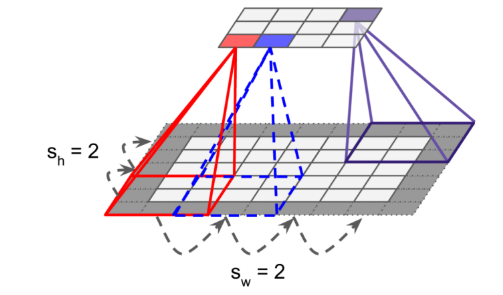

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['1.PNG']))
im

- in the diagram, a 5 x 7 input layer (plus zero padding) is connected to a 3 x 4 layer, using 3 x 3 receptive fields and a stride of 2 
- in this example, the stride is the same in both directions, but it doesn't always have to be this way

### Filters

Saving 2.PNG to 2.PNG


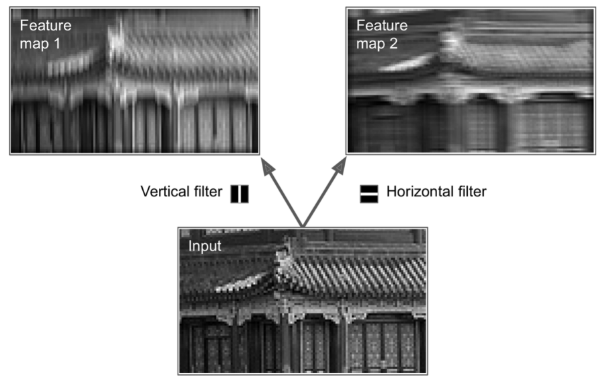

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['2.PNG']))
im

- a neuron's weights can be represented as a small image the size of the receptive field
- for example, the code above shows 2 possible sets of weights, called *filters* (or *convolution kernels*) 
- the first one is represented as a black square with a vertical white line 
 - all the inputs will get multiplied by 0, except for the ones located in the central vertical line
- the second filter is a black square with a horizontal white line in the middle
 - once again, neurons using these weights will ignore everything in their receptive field except for the central horizontal line
---
- if all neurons in a layer use the same vertical line filter (and the same bias term), and you feed the network the input image above, the layer will output the top-left image
 - the vertical white lines get enhanced while the rest gets blurred
- you do not have to define the filters manually: during training, the convolutional layer will automatically learn the most useful filters for its task, and the layers above will learn to combine them into more complex patterns

### Stacking Multiple Feature Maps

- so far, the output of each convolutional layer has been a 2D layer, but in reality, a convolutional layer has multiple filters (you decide how many) and outputs one feature map per filter, so it is more accurately represented in 3D

Saving 3.PNG to 3.PNG


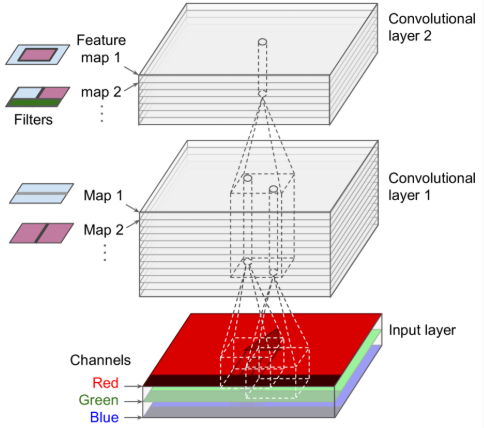

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['3.PNG']))
im

- it has one neuron per pixel in each feature map, and **all neurons within a given feature map share the same parameters** (the same weights and bias term) 
 - neurons in different feature maps use different parameters
- a neuron's receptive field is the same as described earlier, but it extends across all the previous layers' feature maps
- in short, a convolutional layer simultaneously applies multiple trainable filters to its inputs, making it capable of detecting multiple features anywhere in its inputs
---
- having all neurons in a feature map share the same parameters drastically reduces the number of parameters in the model
- once the CNN has learned to recognize a pattern in one location, it can recognize it in any other location
 - in contrast, a DNN can only recognize a learned pattern in that particular location
---
- input images are composed of multiple sublayers: one per *color channel*
- there are typicall 3: red, green, and blue (RGB)
- grayscale images have just 1 channel, but some images may have more (satellite images that capture extra light frequencies such as infrared) 
---
- note that all neurons located in the same row and column but in different feature maps are connected to the outputs of the exact same neurons in the previous layer


### TensorFlow Implementation

- in TensorFlow, each input image is typically represented as a 3D tensor of shape _[height, width, channels]_
- a mini-batch is represented as a 4D tensor of shape _[mini-batch size, height, width, channels]_
- the weights of a convolutional layer are represented as a 4D tensor and the bias terms of a convolutional layer are represented as a 1D tensor
---
- the following code loads 2 sample images using Scikit-Learn's `load_sample_image()` (a colored Chinese temple and a colored flower), then creates 2 filters and applies them to both images, and finally displays one of the resulting feature maps

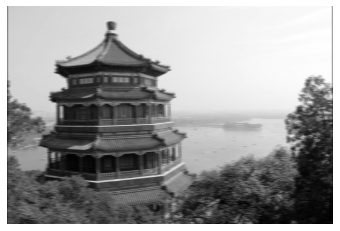

In [0]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape # 4D tensor

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

- let's code through this code: 
 - the pixel intensity for each color channel is represented as a byte from 0 to 255, so we scale these features by dividing by 255 to get floats from 0 to 1
 - then we create two 7 x 7 filters (one with a vertical white line in the middle, and the other with a horizontal white line)
 - we apply them to both images using the `tf.nn.conv2d()` function 
 - we use zero padding (`padding="SAME"`) and a stride of 1
 - finally, we plot one of the resulting feature maps 
---
- the `tf.nn.conv2d()` line deserves more explanation: 
 - `images` is the input mini-batch (a 4D tensor)
 - `filters` is the set of filters to apply (a 4D tensor)
 - `strides` is equal to `1`, but it could also be a 1D array with 4 elements
 - `padding` must be either `"SAME"` or `"VALID"`: if set to `"SAME"`, the convolutional layer uses zero padding if necessary, and if set to `"VALID"`, the convolutional layer doesn't use zero padding and may ignore some rows and columns
---
- instead of manually creating the variables, use the `keras.layers.Conv2D layer`: 

In [0]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

- this code creates a `Conv2D` layer with 32 filters, each 3 x 3, using a stride of 1 (both horizontally and vertically), `"SAME"` padding, and applying the ReLU activation function to its outputs

### Memory Requirements

- another problem with CNNs is that the convolutional layers require a huge amount of RAM
 - this is especially true during training, because the reverse pass of backpropagation requires all the intermediate values computed during the forward pass
- during inference (when making predictions on a new instance), the RAM occupied by one layer can be released as soon as the next layer has been computed, so you only need as much RAM as required by 2 consecutive layers
- for training, however, everything computed furing the forward pass needs to be preserved for the reverse pass, so the amount of RAM needed is (at least) the total amount of RAM required by all layers)

## Pooling Layers

- the second common building block of CNNs: the *pooling layer*
- once you understand convolutional layers, the pooling layers are quite easy to grasp
- **their goal is to *subsample* (shrink) the input image in order to reduce the computational load, the memory usage, and the number of parameters** (which limits the risk of overfitting)
---
- just like in convolutional layers, each neuron in a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, located within a small rectangular receptive field
 - and just like before, you must also define its size, the stride, and the padding type
---
- however, a pooling neuron has no weights; all it does it aggregate the inputs using an aggregation function such as the max or mean

Saving 4.PNG to 4.PNG


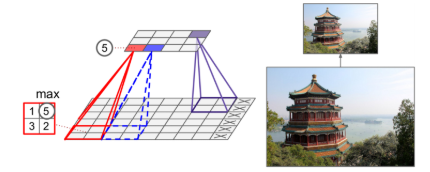

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['4.PNG']))
im

- in this example, we use a 2 x 2 *pooling kernel* (other kernels we've discussed so far had weights, but pooling kernels do not) with a stride of 2 and no padding
- only the max input value in each receptive field makes it to the next layer, while the other inputs are dropped
- because of the stride of 2, the output image has half the height and half the width of the input image (rounded down since no padding)
---
- a pooling layer typically works on every input channel independently, so the output depth is the same as the input depth
---
- a max pooling layer also introduces some level of *invariance* to small translations
 - more specifically, max pooling offers a small amount of rotational invariance and a slight scale invariance
- such invariance, however, can actually be useful in cases where the prediction should not depend on these details, such as in classification tasks
 - this is not true for all tasks, such as semantic segmentation (the task of classifying each pixel in an image according to the object that the pixel belongs to)

### TensorFlow Implementation

- the following code creates a max pooling layer using a 2 x 2 kernel
- the strides default by the kernel size, so this layer will use a stride of 2 (both horizontally and vertically) 
- by default, it uses `"VALID"` padding (no padding at all)

In [0]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [0]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


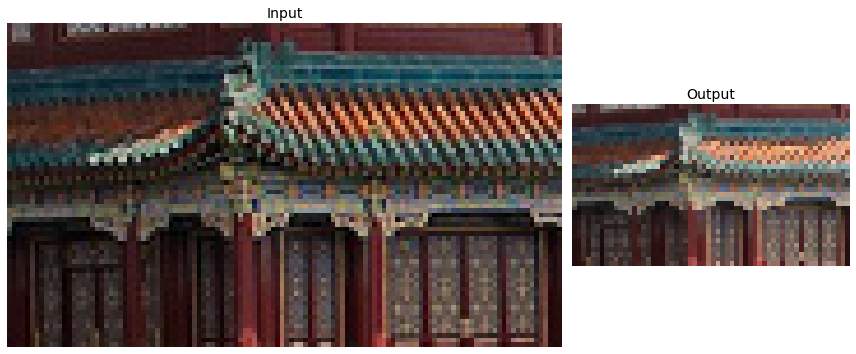

In [0]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

- to create an *average pooling layer*, just use `AvgPool2D` instead of `MaxPool2D`
 - it works exactly like a max pooling layer, but it computes the mean instead of the max
- max pooling layers are more popular and generally perform better
 - max pooling preserves only the strongest features, getting rid of all the meaningless ones, so the next layers get a cleaner signal to work with
- moreover, max pooling offers stronger translation invariance than average pooling, and it requires slightly less to compute

### Global Average Pooling Layer

- one last type of pooling layer that you will often see in modern architectures is the *global average pooling layer*
- it works very differently: all it does is compute the mean of each entire feature map
 - it just outputs a single number per feature map per instance
- although this is extremely destructive (most of the information in the feature map is lost), it can be useful as the output layer

In [0]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

- the code above is equivalent to this simple `Lambda` layer, which computes the mean over the spatial dimensions (height and width)

In [0]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

- now that you know all the building blocks to create a convolutional neural network, let's learn how to assemble them:

## CNN Architectures

- typical CNN architectures stack a few convolutional layers (each one generally followed by an ReLU layer), then a pooling layer, then another few convolutional layers (+ReLU), then another pooling layer, and so on
- the image gets smaller and smaller as it progresses through the network, but it also typically gets deeper and deeper (with more feature maps), thanks to the convolutional layers
- at the top of the stack (near the output layer), a regular feedforward neural network is added, composed of a few fully connected layers (+ReLUs), and a final layer outputs the prediction (a softmax layer that outputs estimated class probabilities)

Saving 5.PNG to 5.PNG


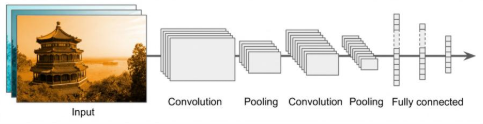

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['5.PNG']))
im

- **a common mistake is to use convolution kernels that are too large**
 - for example, instead of using a convolutional layer with a 5 x 5 kernel, stack two layers with 3 x 3 kernels: it will use fewer parameters and require fewer computations (and usually perform better)
- one exception, however, is for the first convolutional layer: it will typically have a large kernel (5 x 5) and a stride of 2 or more
 - this will reduce the spatial dimension of the image without losing too much information
---
- here is how you can implement a simple CNN to tackle the Fashion MNIST dataset:

### CNN Model Example and Explanation

In [0]:
# creating the datasets
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# scaling the datasets
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis] # np.newaxis increases array by 1 dimension
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
# creating our first convolutional neural network
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, # partial() "freezes" the hyperparameters unless otherwise specified
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]), # images are 28 x 28 pixels with 1 color channel (grayscale)
    keras.layers.MaxPooling2D(pool_size=2), # greater the pool_size, the less detail in the resulting shruken image
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(), # flatten inputs as a dense network expects a 1D array of features
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

- `partial()` is used for partial function application which “freezes” some portion of a function’s arguments and/or keywords resulting in a new object with a simplified signature
---
- **let's go through this model**: 
- the first layer uses 64 fairly large filters (7 x 7) **but no stride because the input images are not very large**
 - it also sets `input_shape=[28, 28, 1]` because the images are 28 x 28 pixels, with a single color channel (grayscale)
- next, we have a pooling layer which uses a pool size of 2, so it divides each spatial dimension by a factor of 2 
- then we repeat the same structure twice: 2 convolutional layers followed by a max pooling layer
 - **for larger images, we could repeat this structure several more times** (the number of repetitions is a tunable hyperparameter)
- as we climb up the CNN toward the output layer, the number of filters grows (it is initially 64, then 128, then 256)
 - it is common to double the number of filters after each pooling layer: since a pooling layer divides each spatial dimension by a factor of 2, we can afford to double the number of feature maps in the next layer without fear of exploding the number of parameters, memory usage, or computational load
- finally, the fully connected region at the top of our network is composed of 2 hidden dense layers and a dense output layer
 - note that we must flatten the inputs, since a dense network expects a 1D array of features for each instance
 - we also add 2 dropout layers with a dropout rate of 50% each to reduce overfitting


In [0]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7187 - accuracy: 0.7477 - val_loss: 0.3653 - val_accuracy: 0.8694
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4214 - accuracy: 0.8583 - val_loss: 0.3316 - val_accuracy: 0.8834
Epoch 3/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3622 - accuracy: 0.8801 - val_loss: 0.3000 - val_accuracy: 0.8882
Epoch 4/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3260 - accuracy: 0.8910 - val_loss: 0.2838 - val_accuracy: 0.8934
Epoch 5/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3095 - accuracy: 0.8950 - val_loss: 0.2812 - val_accuracy: 0.8974
Epoch 6/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2860 - accuracy: 0.9027 - val_loss: 0.2755 - val_accuracy: 0.8994
Epoch 7/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.2804 - accuracy: 0.9060 - val_loss: 0.2853 - val_ac

In [0]:
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

313/313 [==============================] - 1s 3ms/step - loss: 0.2875 - accuracy: 0.9005


- this CNN reaches ~90% accuracy on the test set: it's not state of the art, but it's pretty good, and clearly much better than what we've achieved in previous chapters on MNIST

## LeNet-5

- the LeNet-5 architecture is perhaps the most widely known CNN architecture

Saving 6.jpg to 6 (1).jpg


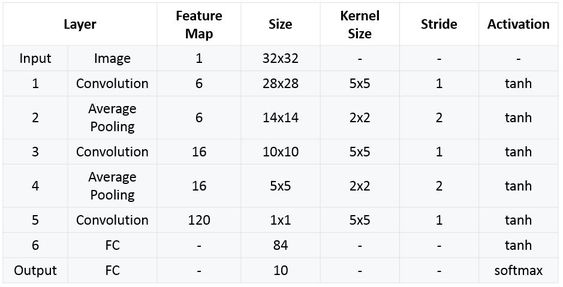

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['6.jpg']))
im

- MNIST images are 28 x 28 pixels, but they are zero-padded to 32 x 32 pixels and normalized before being fed to the network
 - the rest of the network does not use any padding, which is why the size keeps shrinking as the image progresses through the network
- the average pooling layers are slightly more complex than usual: each neuron computes the mean of its inputs, then multiplies the result by a learnable coefficient (one per map) and adds a learnable bias term (one per map), then finally applies the activation function
- most neurons in C3 maps are connected to neurons in only 3 or 4 S2 maps (instead of all 6 S2 maps)
- the output layer is a bit special: instead of computing the matrix multiplication of the inputs and the weight vector, each neuron outputs the square of the Euclidian distance between its input vector and its weight vector
 - each output measures how much the image belongs to a particular digit class
 - the cross-entropy cost function is now preferred, as it penalizes bad predictions much more, producing larger gradients and converging faster

## AlexNet

- similar to LeNet-5, only much larger and deeper
- AlexNet was the first to stack convolutional layers directly on top of one another, instead of stacking a pooling layer on top of each convolutional layer

Saving 7.png to 7.png


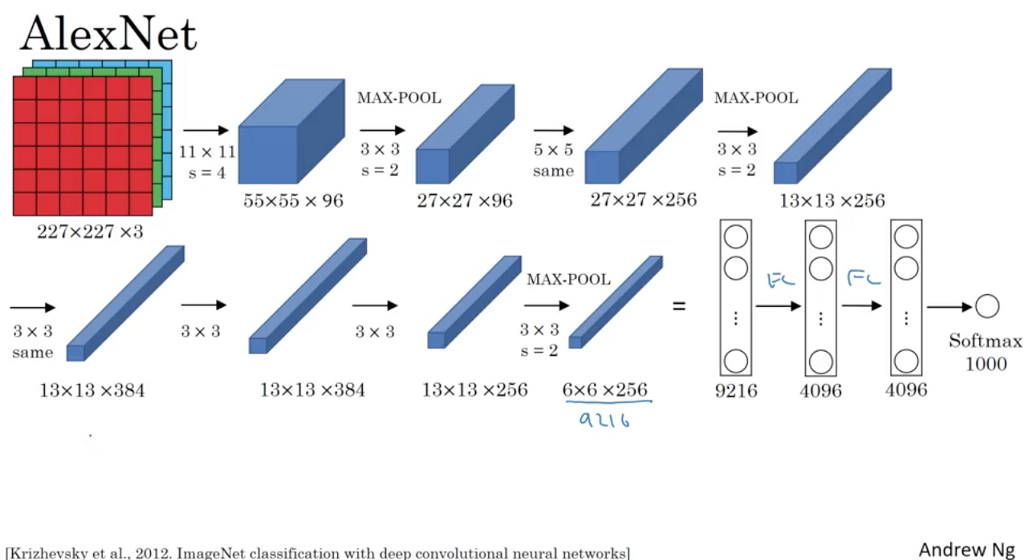

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['7.png']))
im

- to reduce overfitting, the AlexNet uses two regularization techniques:
 - first, it applies dropout with a 50% dropout rate during training to the outputs of layers F9 and F10
 - second, AlexNet performes *data augmentation* by randomly shifting the training images by various offsets, flipping them horizontally, and changing the lighting conditions
---
- **data augmentation** artificially increases the size of the training set by generating many realistic variants of each training instance, which reduces overfitting
 - for example, you can slightly shift, rotate, and resize every picture in the training set by various amounts and add the resulting pictures to the training set
 - this forces the model to be more tolerant to variations in the position, orientation, and size of the objects in the pictures
 - by combining these transformations, you can greatly increase the size of your training set
---
- AlexNet also uses a competetive normalization step immediately after the ReLU step of layers C1 and C3, called *local response normalization* (LRN): the most strongly activated neurons inhibit other neurons located at the same position in neighboring feature maps 
 - this encourages different feature maps to specialize, pushing them apart and forcing them to explore a wider range of features, ultimately improving generalization

## GoogLeNet

- GoogLeNet is much deeper than previous CNNs
- GoogLeNet found huge success using subnetworks called *inception modules*, which allow it to use parameters much more efficiently than previous architectures: GoogleNet has 10 times fewer parameters than AlexNet despite being much deeper

### Inception Module

Saving 8.webp to 8.webp


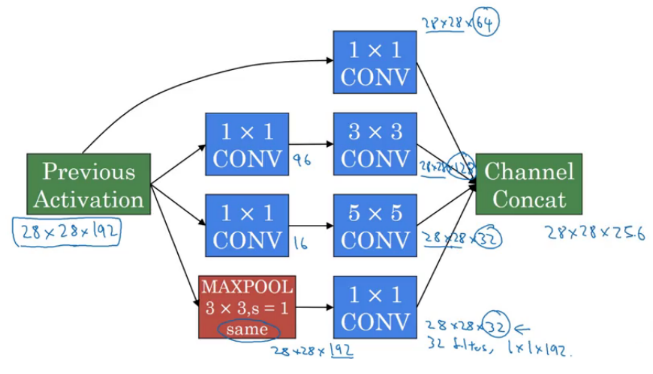

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['8.webp']))
im 

- the image above shows the architecture of an inception module
- the notation "3 x 3 + 1(S)" means that the layer uses a 3 x 3 kernel, a stride of 1, and `"SAME"` padding
- the input signal is first copied and fed to four different layers
- all convolutional layers use the ReLU activation function
- **the second set of convolutional layers uses different kernel sizes (1 x 1, 3 x 3, and 5 x 5), allowing them to capture patterns at different scales**
- **note that every layer in the inception module uses a stride of 1 and `"SAME"` padding, so their outputs all have the same height and width as their inputs**
 - this makes it possible to concatenate all the outputs along the depth dimension in the final *depth concatenation layer* (stack the feature maps from all 4 top convolutional layers)
 - this concatenation layer can be implemented in TensorFlow using `tf.concat()` with `axis=3` (axis for depth)
---
- convolutional layers with 1 x 1 kernels only look at one pixel at a time
 - although they cannot capture spatial patterns, they can capture patterns along the depth dimension
 - they are configured to output fewer feature maps than their inputs, so they serve as *bottleneck layers*, meaning they reduce dimensionality (this cuts the computational cost and the number of parameters, which speeds up training and improves generalization)
 - each pair of convolutional layers ([1 x 1, 3 x 3]) and ([1 x 1, 5 x 5]) acts like a single powerful convolutional layer, capable of capturing more complex patterns
---
- **overall, think of the whole inception module as a convolutional layer on steroids**

### GoogLeNet Architecture

Saving 9.PNG to 9.PNG


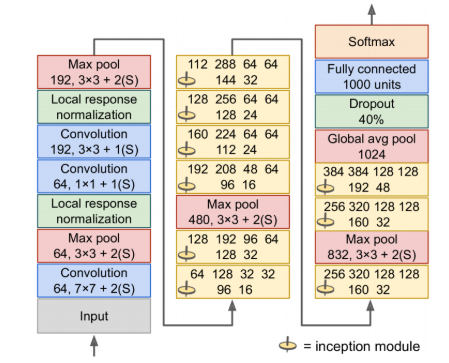

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['9.PNG']))
im 

- all convolutional layers use the ReLU activation function
- contains 9 inception modules
- the first 2 layers divide the image's height and width by 4 (so its area is divided by 16), to reduce the computational load
 - **the first layer uses a large kernel size so a lot of information is preserved**
- **then the local response normalization layer ensures that the previous layers learn a wide variety of features**
- 2 convolutional layers follow, where the first acts like a bottleneck layer
 - as previously explained, you can think of this pair as a smarter convolutional layer
- again, a local response normalization layer ensures that the previous layers capture a wide variety of patterns
- next, a max pooling layer reduces the image height and width by 2 to speed up computations (again)
- then comes the tall stack of 9 inception modules, interleaved with a couple max pooling layers to reduce dimensionality and speed up the net
- next, the global average pooling layer outputs the mean of each feature map: this drops any remaining spatial information
 - GoogLeNet input images are typically expected to be 224 x 224 pixels, so after 5 max pooling layers, each dividing the height and width by 2 (strides of 2), the feature maps are down to 7 x 7 
 - **moreover, it is a classification task, not localization, so it does not matter where the object is**
 - thanks to the dimensionality reduction brought by this layer, there is no need to have several fully connected layers at the top of the CNN (like in AlexNet), which considerably reduces the number of parameters and the risk of overfitting
- finally, there is dropout for regularization, a fully connected layer with 1,000 units (since there are 1,000 classes), and a softmax activation function to output estimated class probabilities

## VGGNet

Saving 10.png to 10.png


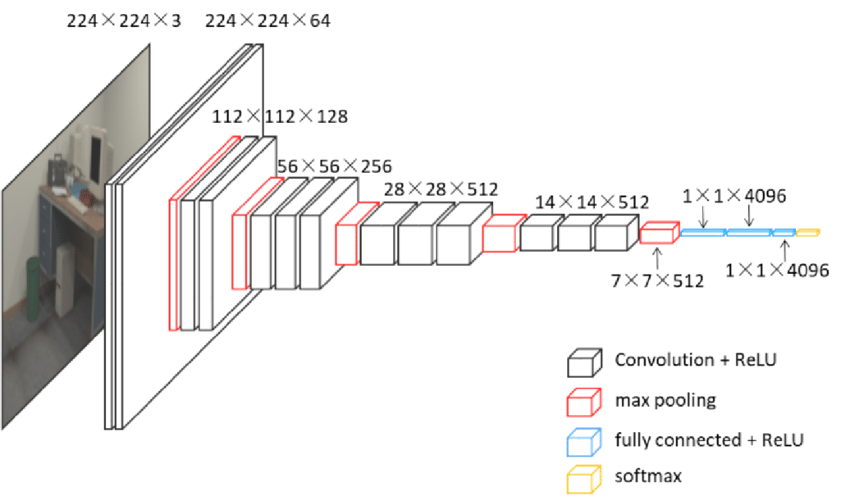

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['10.png']))
im 

- the runner-up to the GoogLeNet
- unlike the GoogLeNet, it had a very simple and classical architecture:
 - 2 or 3 convolutional layers followed by a pooling layer 
 - this architecture was repeated, reaching a total of just 16 or 19 convolutional layers (depending on the VGG variant), plus a final dense network with 2 hidden layers and the output layer
 - it used ony 3 x 3 filters, but included many

## ResNet

- *Residual Network* (or *ResNet*)
- the winning variant used an extremely deep CNN composed of 152 layers
 - **confirmed the general trend: models are getting deeper and deeper with fewer and fewer parameters**
- the key to training such a deep network is to use *skip connections*: the signal feeding into a layer is also added to the output of a layer located a bit higher up the stack

### Residual Learning

- when training a neural network, the goal is to make it model a target function $h(x)$
- if you add the input $x$ to the output of the network (add a skip connection), then the network will be forced to model $f(x) = h(x) - x$ rather than just $h(x)$ 
 - this is called *residual learning*

Saving 11.png to 11.png


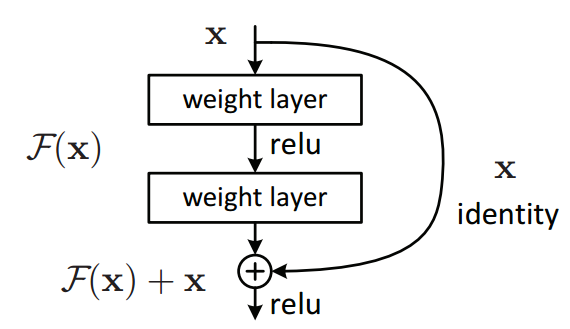

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['11.png']))
im 

- when you initialize a regular neural network, its weights are close to 0, so the network just outputs values close to 0
- if you add a skip connection, the resulting network just outputs a copy of its inputs
- if the target function is fairly close to the identity function (which it often is), this will considerably speed up training
---
- **moreover, if you add many skip connections, the network can start making progress even if several layers have not started learning yet**
- thanks to skip connections, the signal can easily make its way across the whole network
- the deep residual network can be seen as a stack of *residual units* (RUs), where each residual unit is a small neural network with a skip connection

### ResNet Architecture

Saving 12.PNG to 12.PNG


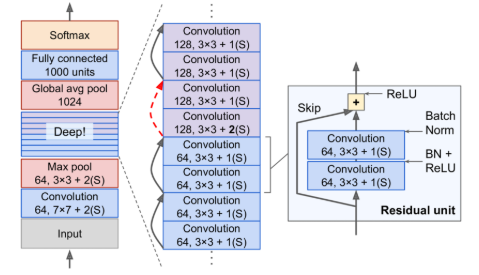

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['12.PNG']))
im 

- suprisingly simple: in between is just a very deep stack of simple residual units
 - each residual unit is composed of 2 convolutional layers (and no pooling layer), with Batch Normalization and ReLU activation, using 3 x 3 kernels and preserving spatial dimensions (stride 1, `"SAME"` padding)
- the number of feature maps is doubled every few residual units, at the same time as their height and width are halved (using a convolutional layer with stride 2)
 - when this happens, the inputs cannot be added directly to the outputs of the residual unit because they don't have the same shape
 - to solve this problem, the inputs are passed through a 1 x 1 convolutional layer with stride 2 and the right number of output feature maps
---
- ResNet-34 is the ResNet with 34 layers (only counting the convolutional layers and the fully connected layer) containing 3 residual units that output 64 feature maps, 4 RUs with 128 maps, 6 RUs with 256 maps, and 3 RUs with 512 maps
- deeper ResNets, such as ResNet-152, use slightly different residual units

## Xception 

- proposed by françois chollet (author of Keras) in 2016
- significantly outperformed Inception v3 on a huge vision task (350 million images and 17,000 classes)
- merges the ideas of GoogLeNet and ResNet, but replaces the inception modules with a special type of layer called a *depthwise separable convolution layer* 

### Separable Convolutional Layers

 - while regular convolutional layers use filters that try to simultaneously capture spatial patterns (e.g., an oval) and cross-channel patterns (e.g., mouth + nose + eyes = face), a separable convolutional layer makes the strong assumption that spatial patterns and cross-channel patterns can be modeled separately
 - thus it is composed of 2 parts: the first applies a single spatial filter for each input feature map, then the second part looks exclusively for cross-channel patterns (just a regular convolutional layer with 1 x 1 filters) 

Saving 13.PNG to 13.PNG


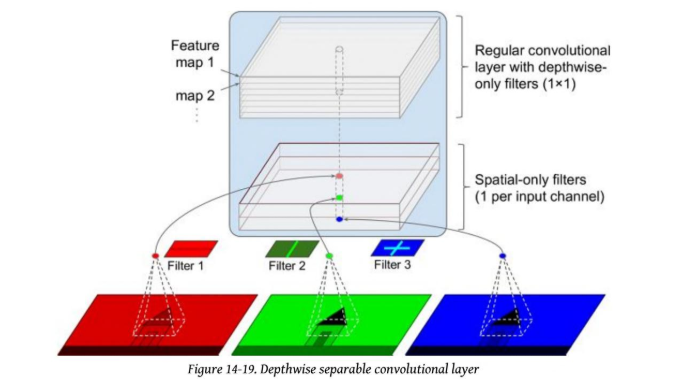

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['13.PNG']))
im 

- avoid using separable convolutional layers after layers that have too few channels, such as the input layer
- Xception architecture starts with 2 regular convolutional layers, but then the rest of the architecture uses only separabe convolutions (34 in all), plus a few max pooling layers and the usual final layers (a global average pooling layer and a dense output layer)
---
- an inception module contains convolutional layers with 1 x 1 filters: these look exclusively for cross-channel patterns
- however, the convolutional layers that sit on top of them are regular convolutional layers that look for both spatial and cross-channel patterns
- therefore, you can think of an inception module as an intermediate between a regular convolutional layer (considers spatial patterns and cross-channel patterns jointly) and a separable convolutional layer (considers them separately) 
- in practice, separable convolutional layers generally perform better
 - separable convolutional layers use fewer parameters, less memory, and fewer computations than regular convolutional layers, and in general they perform better, so you should consider using them by default

## SENet

- the Squeeze-and-Excitation Network (SENet)
- this architecture extends existing architectures such as inception networks and ResNets, and boosts their performance
 - the boost comes from the fact that a SENet adds a small neural network, called an *SE block*, to every unit in the original architecture (to every inception module or to every residual unit):

Saving 14.PNG to 14.PNG


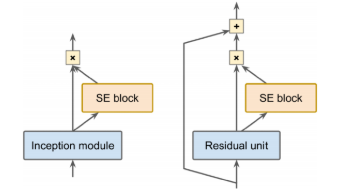

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['14.PNG']))
im 

- an SE block analyzes the output of the unit it is attached to, focusing exclusively on the depth dimension (it does not look for spatial patterns), and it learns which features are usually most active together
 - it then uses this information to recalibrate the feature maps:

Saving 15.PNG to 15.PNG


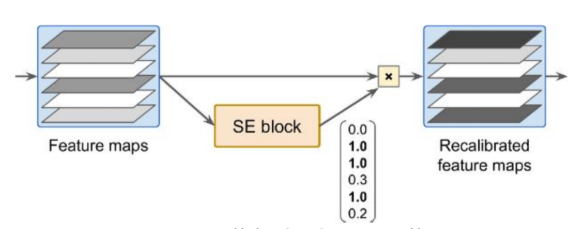

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['15.PNG']))
im 

- for example, an SE block may learn that mouths, noses, and eyes usually appear together in pictures: if you see a mouth and a nose, you should expect to see eyes as well
 - so if the block sees a strong activation in the mouth and nose feature maps, but only mild activation in the eye feature map, it will boost the eye feature map (more accurately, it will reduce irrelevant feature maps)
 - if the eyes were somewhat confused with something else, this feature map recalibration will help resolve ambiguity
---
- an SE block is composed of just 3 layers: a global average pooling layer, a hidden dense layer using ReLU, and a dense output layer using sigmoid:

Saving 16.PNG to 16.PNG


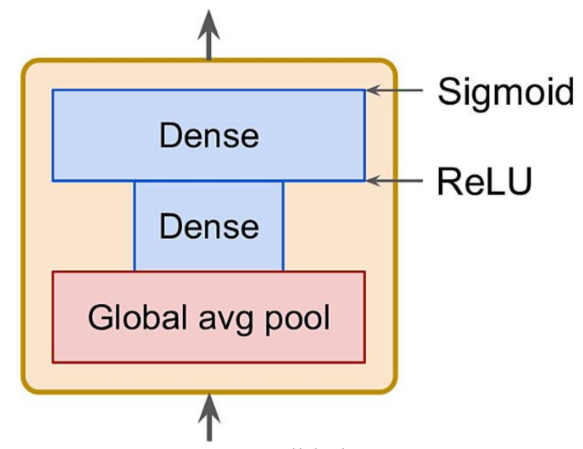

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['16.PNG']))
im 

- **as stated previously, the global average pooling layer computes the mean activation for each feature map: for example, if its input contains 256 feature maps, it will output 256 numbers representing the overall level of response for each filter**
- the next layer is where the "squeeze" happens: this layer has significantly fewer than 256 neurons, so the 256 numbers get compressed into a small vector (16 dimensions)
 - this is a low-dimensional vector representation (an embedding) of the distribution of feature responses
 - this bottleneck step forces the SE block to learn a general representation of the feature combinations
- finally, the output layer takes the embedding and outputs a recalibration vector containing one number per feature map (256), each between 0 and 1 (as shown in the image)
 - the feature maps are then multiplied by this recalibration vector, so **irrelevant features (with low recalibration scores) get scaled down while relevant features (with high recalibration scores) are left alone**

## Implementing a ResNet-34 CNN Using Keras

- let's implement a ResNet-34 from Scratch using Keras
- first, let's create a `ResidualUnit` layer:

In [0]:
# partial() "freezes" the hyperparameters unless otherwise specified
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, 
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

- in the constructor, we create all the layers we will need: the main layers are the ones on the right side of the diagram (shown in the ResNet section), and the skip layers are the ones on the left (only needed if the stride is greater than 1)
- then in the `call()` method, we make the inputs go through the main layers and the skip layers (if any), then we add both outputs and apply the activation function
---
- next we can build the ResNet-34 using a `Sequential` model, since it's really just a long sequence of layers (we can treat each residual unit as a single layer now that we have the `ResidualUnit` class):

In [0]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

- the only tricky part in this code is the loop that adds the `ResidualUnit` layers to the model: as explained earlier, the first 3 RUs have 64 filters, then the next 4 RUs have 128 filters, and so on
- we then set the stride to 1 when the number of filters is the same as in the previous RU, or else we set it to 2
---
- it's amazing that in fewer than 40 lines of code, we can build the model that won the ILSVRC 2015 challenge
 - this demonstrates both the elegance of the ResNet model and the expressiveness of the Keras API
- implementing the other CNN architectures is not much harder, however Keras comes with several of these architectures built in, so let's use those instead

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

## Using Pretrained Models from Keras

- in general, you won't have to implement standard models like GoogLeNet or ResNet manually, since pretrained networks are readily available with a single line of code in the `keras.applications` package
- for example, you can load the ResNet-50 model, pretrained on ImageNet, with the following line of code:

In [0]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102973440/102967424 [==============================] - 1s 0us/step


- this created a ResNet-50 model and downloaded weights pretrained on the ImageNet dataset
- **to use it, you first need to ensure that the images have the right size**
 - a ResNet-50 model expects 224 x 224-pixel images (other models may expect other sizes), so let's use TensorFlow's `tf.image.resize()` function to resize the images we loaded earlier:

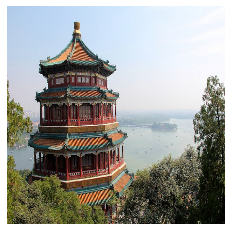

In [0]:
images_resized = tf.image.resize(images, [224, 224])

plot_color_image(images_resized[0]) # example image from the beginning of the chapter
plt.show() # aspect ratio not preserved (image is clearly stretched)

- `tf.image.resize()` does not preserve the aspect ratio, however, 
`tf.image.crop_and_resize()` resizes the images and preserves their aspect ratio:

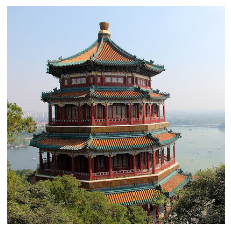

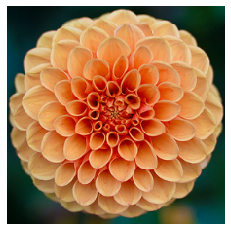

In [0]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

- **the pretrained models assume that the images are preprocessed in a specific way**
- in some cases, they may expect the inputs to be scaled from 0 to 1, or -1 to 1, and so on
- each model provides a `preprocess_input()` function that you can use to preprocess your images
- these functions assume that the pixel values range from 0 to 255, so we must multiply them by 255 (since earlier we scaled them to the 0 to 1 range):

In [0]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

- now we can use the pretrained model to make predictions:

In [0]:
Y_proba = model.predict(inputs)
Y_proba.shape

(2, 1000)

- as usual, the output `Y_proba` is a matrix with one row per image and one column per class (in this case, there are 1,000 classes)
- if you want to display the top *K* predictions, including the class name and the estimated probability of each predicted class, use the `decode_predictions()` function:
 - for each image, it returns an array containing the top *K* predictions, where each prediction is represented as an array containing the class identifier, its name, and the corresponding confidence score

In [0]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



- as you can see, it is very easy to create a pretty good image classifier using a pretrained model
- other vision models are available in `keras.applications`, including several ResNet variants, GoogLeNet variants like Inception-v3 and Xception, VGGNet variants, and MobileNet and MobileNetV2 (lightweight models for use in moble applications)
---
- **however, if you need an image classifier for classes of images that are not part of ImageNet, you will benefit from the pretrained models to perform transfer learning**

## Pretrained Models for Transfer Learning

- if you want to build an image classifier but you do not have enough training data, then it is often a good idea to reuse the lower layers of a pretrained model, as previously discussed in Chapter 11
- for example, let's train a model to classify pictures of flowers, reusing a pretrained Xception model
- first, let's load the dataset using TensorFlow Datasets:

In [17]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


In [0]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [0]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [0]:
n_classes = info.features["label"].num_classes
n_classes

5

- unfortunately, there is only a `"train"` dataset: no test or validation set, so we need to split the training set
- the TF Datasets project provides an API for this
- for example, let's take the first 10% of the dataset for testing, the next 15% for validation, and the remaining 75% for training:

In [0]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

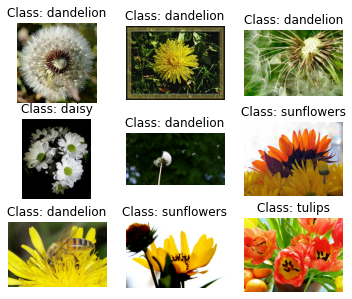

In [0]:
plt.figure(figsize=(6, 5))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

- next we must preprocess the images
- the CNN expects 244 x 244 images, so we need to resize them
- we also need to run the images through Xception's `preprocess_input()` function:

In [0]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

- here is some slightly fancier preprocessing: data augmentation:
 - we use tf.image.random_crop() to randomly crop the images and tf.image.random_flip_left_right() to randomly flip the images horizontally, and so on


In [0]:
# data augmentation
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

- **let's apply this preprocessing function to all three datasets, shuffle the training set, and add batching and prefetching to all the datasets**:

In [0]:
batch_size = 32

# shuffling the training set
train_set = train_set_raw.shuffle(1000).repeat() 

# applying the preprocessing function, batching, and prefetching to all 3 datasets
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

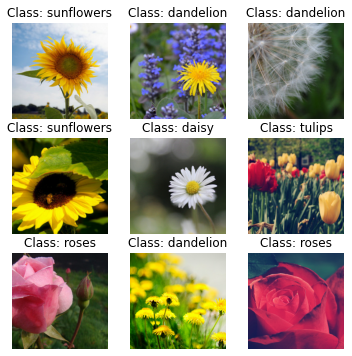

In [0]:
plt.figure(figsize=(6, 6))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

- next, let's load an Xception model, pretrained on ImageNet
- we exclude the top of the network by setting `include_top=False`: this excludes the global average pooling layer and the dense output layer
- we then add our own global average pooling layer based on the output of the base model, followed by a dense output layer with one unit per class using the softmax activation function
- finally, we create the Keras `Model`:

In [0]:
base_model = keras.applications.xception.Xception(weights="imagenet", # pretrained on ImageNet
                                                  include_top=False) # excludes the top of the network                 
avg = keras.layers.GlobalAveragePooling2D()(base_model.output) # our own global average pooling layer based on the output of the base model
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 2s 0us/step


In [0]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name) # we have a lot of separable convolutional layers (as discussed earlier)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_5
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_6
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_7
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_a

- as explained in Chapter 11, **it's usually a good idea to freeze the weights of the pretrained layers, at least at the beginning of training**:
 - since our model uses the base model's layers directly, we have to run this loop with `layer.trainable = False`
 - if our model used the `base_model` object itself, we could just set `base_model.trainable = False`

In [0]:
# freezing the weights of the pretrained layers
for layer in base_model.layers:
    layer.trainable = False 

In [0]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 10s 122ms/step - loss: 1.6721 - accuracy: 0.7769 - val_loss: 1.2738 - val_accuracy: 0.8162
Epoch 2/5
86/86 [==============================] - 9s 110ms/step - loss: 0.5704 - accuracy: 0.9084 - val_loss: 0.9563 - val_accuracy: 0.8621
Epoch 3/5
86/86 [==============================] - 9s 110ms/step - loss: 0.3873 - accuracy: 0.9201 - val_loss: 0.7829 - val_accuracy: 0.8713
Epoch 4/5
86/86 [==============================] - 9s 110ms/step - loss: 0.2738 - accuracy: 0.9357 - val_loss: 0.7140 - val_accuracy: 0.8750
Epoch 5/5
86/86 [==============================] - 9s 110ms/step - loss: 0.2175 - accuracy: 0.9451 - val_loss: 0.6750 - val_accuracy: 0.8787


- after training the model for a few epochs, its validation accuracy should reach about 75-80% and stop making much progress
 - this means that the top layers are now pretty well trained, so we are ready to unfreeze all the layers
- **this time we use a much lower learning rate to avoid damaging the pretrained weights**:

In [0]:
# unfreezing the weights of the pretrained layers
for layer in base_model.layers:
    layer.trainable = True

- the cell below takes an extremely long time to run:

In [0]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, # lower learning rate as to not damage the pretrained weights
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

- with that, you can start training amazing image classifiers, but there's more to computer vision than just classification
- for example, what if you also want to know *where* the flower is in the picture

## Classification and Localization

- localizing an object in a picture can be expressed as a regression task: to predict a bounding box around the object
- a common approach is to predict the horizontal and vertical coordinates of the object's center, as well as its height and width
 - this means that we have 4 numbers to predict
- **fortunately, it does not require much change to the model; we just need to add a second dense output layer with 4 units (typically on top of the global average pooling layer), which can be trained using MSE loss**: 

In [0]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)

83689472/83683744 [==============================] - 1s 0us/step


In [0]:
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg) # same as before
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])

- images already preprocessed in the "Pretrained Models for Transfer Learning" section

In [0]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

- but now we have a problem: the flowers dataset does not have bounding boxes around the flowers, so we need to add them ourselves
- this is often one of the hardest and most costly parts of a Machine Learning project: getting the labels
- to annotate images with bounding boxes, you may want to use an open source image labeling tool like VGG Image Annotator, LabelImg, OpenLabeler, or ImgLab, or perhaps a commercial tool like LabelBox or Supervisely
---
- the bounding boxes should be normalized so that the horizontal and vertical coordinates, as well as the height and width, all range from 0 to 1
---
- let's suppose you've obtained the bounding boxes for every image in the flowers dataset (for now we will assume there is a single bounding box per image)
- you then need to create a dataset whose items will be batches of preprocessed images along with their class labels and bounding boxes
- each item should be a tuple of the form `(images, (class_labels, bounding_boxes))`
- then you are ready to train your model:

In [0]:
def add_random_bounding_boxes(images, labels): # this is our only option for now
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [0]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 2s 303ms/step - loss: 1.3339 - dense_3_loss: 1.5892 - dense_4_loss: 0.3124 - dense_3_accuracy: 0.2625 - dense_4_accuracy: 0.2875
Epoch 2/2
5/5 [==============================] - 1s 296ms/step - loss: 1.1374 - dense_3_loss: 1.3736 - dense_4_loss: 0.1926 - dense_3_accuracy: 0.5125 - dense_4_accuracy: 0.2562


- the MSE often works fairly well as a cost function to train the model, but it's not a great metric evaluate how well the model can predict bounding boxes
- for this, the most common metric is the *Intersection over Union* (IoU): the area of overlap between the predicted bounding box and the target bounding box, divided by the area of the union
- in `tf.keras`, it is implemented by the `tf.keras.metrics.MeanIoU` class

Saving 17.PNG to 17.PNG


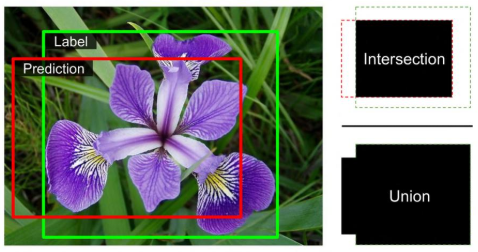

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['17.PNG']))
im 

- so far we've examined cases where the image contains a single object, but now let's handle images with multiple objects (as is often the case with flower datasets)

## Object Detection

- the task of classifying and localizing multiple objects in an image is called *object detection*

### Fully Convolutional Networks

- the idea of FCNs was first introduced in a 2015 paper, in which the authors pointed out that you could replace the dense layers at the top of a CNN with convolutional layers
- **to convert a dense layer to a convolutional layer, the number of filters in the convolutional layer must be equal to the number of units in the dense layer, the filter size must be equal to the size of the input feature maps, and you must use `"VALID"` padding**
 - the stride may be set to 1 or more
--- 
- while a dense layer expects a specific input size (since it has a single weight per input feature), a convolutional layer will happily process images of any size 
- since an FCN contains only convolutional layers (and pooling layers, which have the same property), it can be trained and executed on images of any size

### You Only Look Once (YOLO) 

- YOLO is an extremely popular, fast, and accurate object detection architecture
 - it is so fast that it can run in real time on a vidoe

### Mean Average Precision (mAP)

- a very common metric used in object detection tasks is the *mean Average Precision* (mAP)
- as discussed in Chapter 3, the higher the recall, the lower the precision
---
- suppose the classifier has 90% precision at 10% rrecall, but 96% precision at 20% recall: there's really no trade-off here: it simply makes more sense to use the classifier at 20% recall rather than at 10% recall, as you will get both higher recall and higher precision
- so instead of looking at the precision *at* 10% recall, we should really be looking at the *maximum* precision that the classifier can offer with at least 10% recall (it would be 96%, not 90%)
- therefore, one way to get a fair idea of the model's performance is to compute the maximum precision you can get with at least 0% recall, then 10% recall, then 20%, and so on up to 100%, and then calculate the mean of these maximum precisions
 - this is called the *Average Precision* (AP) metric
- when there are more than 2 classes, we can compute the AP for each class, and then compute the mean AP (mAP)
---
- in an object detection system, there is an additional level of complexity: what if the system detected the correct class, but the wrong location (the bounding box is completely off)
 - surely we would not count this as a positive prediction
- one approach is to define an IOU threshold: for example, we may consider that a prediction is correct only if the IOU is greater than 0.5, and the predicted class is correct


## Semantic Segmentation

Saving 18.PNG to 18.PNG


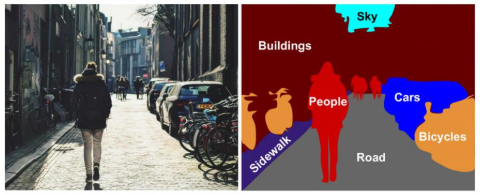

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['18.PNG']))
im 

- in *semantic segmentation*, each pixel is classified according to the class of the object it belongs to
- different objects of the same class are *not* distinguished
 - for example, all the bicycles on the right side of the segmented image end up as one big lump of pixels
---
- the main difficulty in this task is that when images go through a regular CNN, they gradually lose their spatial resolution (due to the layers with strides greater than 1)
 - so a regular CNN may end up knowing that there's a person somewhere in the bottom left of the image, but that will be the extent of its precision
---
- just like for object detection, there are many different approaches to tackle this problem
- one approach is to start by taking a pretrained CNN and turning it into a FCN:
 - **the CNN applies an overall stride of 32 to the input image (if you add up all the strides greater than 1), meaning the last layer outputs feature maps that are 32 times smaller than the input image**
 - this is clearly ttoo coarse, so a single *upsampling layer* is added, which multiplies the resolution by 32
---
- there are several solutions available for upsampling (increasing the size of an image), but in our example we use a *transposed convolutional layer*:
 - it is equivalent to first stretching the image by inserting empty rows and columns (full of 0s), then performing a regular convolution
 - alternatively, some people prefer to think of it as a regular convolutional layer that uses fractional strides (1/2) 
- the transposed convolutional layer can be initialized to perform something close to linear interpolation, but since it is a trainable layer, it will learn to do better during training
- in `tf.keras`, you can use the `Conv2DTranspose` layer
- **in a transposed convolutional layer, the stride defines how much the input will be stretched (not the size of the filter steps), so the larger the stride, the larger the output**
---
- *instance segmentation* is similar to semantic segmentation, but instead of merging all objects of the same class into one big lump, each object is distinguished from the others (it identifies each individual bicycle) 
---
- in conclusion, the field of Deep Computer Vision is vast and moving fast, all based on convolutional neural networks

## TensorFlow Convolution Operations

- TensorFlow offers a few other kinds of convolutional layers: 
- `keras.layers.Conv1D`:
 - layer for 1D inputs, such as a time series or text (sequences of letters or words)
- `keras.layers.Conv3D`: 
 - layer for 3D inputs, such as 3D PET scans
- `dilation_rate`:
 - setting this hyperparameter of any convolutional layer to a value of 2 or more creates a *atrous convolutional layer*, which lets the convolutional layer have a larger receptive field at no computational price and using no extra parameters
- `tf.nn.depthwise_conv2d()`:
 - used to create a *depthwise convolutional layer` (but you need to create the variables yourself)

## Exercises 

1) *What are the main advantages of a CNN over a fully connected DNN for image classification?* 

---

2) *Consider a CNN composed of three convolutional layers, each with 3 x 3 kernels, a stride of 2, and `"SAME"` padding. The lowest layer outputs 100 feature maps, the middle one outputs 200, and the top one outputs 400. The input images are RGB images of 200 x 300 pixels.*

*What is the total number of parameters in the CNN? If we are using 32-bit floats, at least how much RAM will this network require when making a prediction for a single instance? What about when training on a mini-batch of 50 images?*

---

3) *If your GPU runs out of memory while training a CNN, what are five things you could try to solve the problem?*

---

4) *Why would you want to add a max pooling layer rather than a convolutional layer with the same stride?*

---

5) *When would you want to add a local response normalization layer?*

---

6) *Can you name the main innovations in AlexNet, compared to LeNet-5? What about the main innovations in GoogLeNet, ResNet, SENet, and Xception?*

---

7) *What is a fully convolutional network? How can you convert a dense layer into a convolutional layer?*

---

8) *What is the main technical difficulty of semantic segmentation?*



1) 
- Because consecutive layers are only partially connected and because it heavily reuses its weights, a CNN has far less parameters than a fully connected DNN, which makes it faster to train, reduces the risk of overfitting, and requires much less training data.
- When a CNN has learned a kernel that can detect a particular feature, it can detect that feature anywhere in the image. In contrast, when a DNN learns a feature in one location, it can detect it only in that particular location. Since images typically have very repetitive features, CNNs are able to generalize much better than DNNs for image processing tasks such as classification, using fewer training examples. 
- Finally, a DNN has no prior knowledge of how pixels are organized; it does not know that nearby pixels are close. A CNN's architecture, however, embeds this prior knowledge. Lower layers typically identify features in small areas of the images, while higher layers combine the lower-level features into larger features. This works well with most natural images, which gives CNNs a decisive head start compared to DNNs.



2) 
- Its first convolutional layer has 3 x 3 kernels and the input has 3 channels (red, green, and blue). Therefore, each feature map has 3 x 3 x 3 weights plus a bias term: 3 x 3 x 3 = 27, 27 + bias term = 28 parameters per feature map. Since the first convolutional layer has 100 feature maps, it has a total of 2,800 parameters.  The second convolutional layer has 3 x 3 kernels and its input is the set of 100 feature maps of the previous layer, so each feature map has 3 x 3 x 100 = 900 weights, plus a bias term. Since it has 200 feature maps, the 2nd layer has 901 x 200 = 180,200 parameters. Finally, the third and last convolutional layer also has 3 x 3 kernels, and its input is the set of 200 feature maps of the previous layers, so each feature map has 3 x 3 x 200 = 1,800 weights, plus a bias term. Since it has 400 feature maps, this layer has a total of 1,801 x 400 = 720,400 parameters. All in all, the CNN has 2,800 + 180,200 + 720,400 = 903,400 parameters. 
 - So essentially, when calculating the number of total parameters in a CNN, the formula for each layer is as follows: ***((the layer's kernel size * the number of input feature maps) + a bias term) * the number of feature maps the layer outputs*** (how many feature maps the layer has)

- Since we are using a stride of 2 and `"SAME"` padding, the horizontal and vertical dimensions of the feature maps are divided by 2 at each layer (rounding up if necessary). So, as the input channels are 200 x 300 pixels, the first layer's feature maps are 100 x 150, the second layer's feature maps are 50 x 75, and the third layer's feature maps are 25 x 38. Since 32 bits is 4 bytes and the first convolutional layer has 100 feature maps, the first layer takes up 4 x 100 x 150 x 100 = 6 million bytes (6 MB). The second layer takes up 4 x 50 x 75 x 200 = 3 million bytes (3 MB). Finally, the third layer takes up 4 x 25 x 38 x d400 = 1,520,000 bytes (1.5 MB). However, once a layer has been computed, the memory occupied by the previous layer can be released, so if everything is well optimized, only 6 + 3 = 9 million bytes (9 MB) of RAM will be required (when the second layer has just been computed, but the memory occupied by the first layer has not been released yet). But wait, you also need to add the memory occupied by the CNN's parameters. We computed earlier that it has 903,400 parameters, each using up 4 bytes, which adds up to 3,613,600 bytes (about 3.6 MB). The total RAM required for making a prediction on a single instance is therefore (at least) 12,613,600 bytes (about 12.6 MB).

- Lastly, let's compute the minimum amount of RAM required when training the CNN on a mini-batch of 50 images. During training, TensorFlow uses backpropagation, which requires keeping all values computed during the forward pass until the backwards pass begins. So we must compute the total RAM required by all layers for a single instance and multiply that by 50. We computed before that the 3 layers require 6, 3, and 1.5 MB (respectively) for each instance. That's a total of 10.5 MB per instance, so for 50 instances, the total RAM required is 525 MB. Add to that the RAM required by the input images, which is 50 x 4 x 200 x 300 x 3 = 36 million bytes (36 MB), plus the RAM required for the model parameters, which is about 3.6 MB. We are up to a total of roughly 525 + 36 + 3.6 = 564.6 MB, and that's really an optimistic bare minimum. 

3) 
- If your GPU runs out of memory while training a CNN, here are 5 options (other than purchasing a GPU with more RAM):
 - Reduce the mini-batch size. 
 - Reduce dimensionality using a larger stride in one or more layers.
 - Remove one or more layers. 
 - Use 16-bit floats instead of 32-bit floats.
 - Distribute the CNN across multiple devices.

4) 
- A max pooling layer has no parameters at all, whereas a convolutional layer has quite a few.

5) 
- A local response normalization layer makes the neurons that most strongly activate inhibit neurons at the same location but in neighboring feature maps, which encourages different feature maps to specialize and push them apart, forcing them to explore a wider range of features. It is typically used in the lower layers to have a larger pool of low-level feature, which the upper layers can build upon.

6) 
- AlexNet is much larger and deeper compared to LeNet-5. AlexNet also stacks convolutional layers directly on top of each other, instead of stacking a pooling layer on top of each convolutional layer. 
- The main innovation in GoogLeNet is the introduction of *inception modules*, which make it possible to have a much deeper net than previous CNN architectures, with fewer parameters. 
- ResNet's main innovation is the introduction of skip connections, which make it possible to go well beond 100 layers. Arguably, its simplicity and consistency are also rather innovative.
- SENet pioneered the idea of using an SE block (a 2-layer dense network) after every inception module in an inception network or after every residual unit in a ResNet to recalibrate the relative impportance of feature maps. 
- Finally, Xception uses depthwise separable convolutional layers, which look at spatial patterns and depthwise patterns separately. 

7) 
- Fully convolutional networks are neural networks composed exclusively of convolutional and pooling layers. FCNs can efficiently process images of any width and height. They are most useful for object detection and semantic segmentation because they only need to look at the image once (instead of having to run a CNN multiple times on different parts of the image). If you have a CNN with some dense layers on top, you can convert these dense layers to convolutional layers to create a FCN: just replace the lowest dense layer with a convolutional layer with a kernel size equal to the layer's input size, with one filter per neuron in the dense layer, and using `"VALID"` padding.
Generally, the stride should be 1, but you can set it to a higher value if you want. The activation function should be the same as the dense layer's. The other dense layers should be converted the same way, but using 1 x 1 filters. 

8) 
- The main technical difficulty of semantic segmentation is the fact that a lot of the spatial information gets lost in a CNN as the signal flows through each layer, especially in pooling layers and layers with a stride greater than 1. This spatial information needs to be restored somehow to accurately predict the class of each pixel. 

---
9) *Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST.*

---
- **all code will be from TensorFlow's Keras implementation**

In [0]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


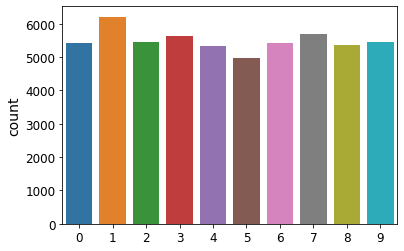

In [3]:
import seaborn as sns

sns.countplot(y_train)

In [0]:
# set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, # partial() "freezes" the hyperparameters unless otherwise specified
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=32, kernel_size=5, input_shape=[28, 28, 1]), # images are 28 x 28 pixels with 1 color channel (grayscale)
    DefaultConv2D(filters=32, kernel_size=5),
    keras.layers.MaxPooling2D(pool_size=2), # greater the pool_size, the less detail in the resulting shruken image
    keras.layers.Dropout(0.25),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2, strides=2),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(), # flatten inputs as a dense network expects a 1D array of features
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [0]:
optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-08, centered=False,
    name='RMSprop'
)

In [0]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [0]:
# reduces the LR by half if the accuracy is not improved after 3 epochs
callback = tf.keras.callbacks.ReduceLROnPlateau( # learning rate annealer
    monitor='val_accuracy', # quantity to be monitored
    factor=0.5, # factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=3, # number of epochs with no improvement after which learning rate will be reduced
    verbose=1, # int. 0: quiet, 1: update messages
    mode='auto', # the direction is automatically inferred from the name of the monitored quantity
    min_lr=0.00001, # lower bound on the learning rate
) 

In [0]:
# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range =0.1, # randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [9]:
epochs = 30
batch_size = 86
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                              steps_per_epoch=len(X_train) // 86, epochs=epochs, # we divide by batch_size to cover entire dataset
                              callbacks=[callback],
                              validation_data=(X_valid, y_valid)) 

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
639/639 [==============================] - 26s 40ms/step - loss: 0.3388 - accuracy: 0.8931 - val_loss: 0.0401 - val_accuracy: 0.9874 - lr: 0.0010
Epoch 2/30
639/639 [==============================] - 25s 39ms/step - loss: 0.1093 - accuracy: 0.9677 - val_loss: 0.0342 - val_accuracy: 0.9906 - lr: 0.0010
Epoch 3/30
639/639 [==============================] - 25s 40ms/step - loss: 0.0840 - accuracy: 0.9749 - val_loss: 0.0653 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 4/30
639/639 [==============================] - 25s 39ms/step - loss: 0.0728 - accuracy: 0.9789 - val_loss: 0.0305 - val_accuracy: 0.9928 - lr: 0.0010
Epoch 5/30
639/639 [==============================] - 25s 40ms/step - loss: 0.0672 - accuracy: 0.9808 - val_loss: 0.0240 - val_accuracy: 0.9932 - lr: 0.0010
Epoch 6/30
639/639 [==============================] - 25s 40ms/step - loss: 0.0660 - accuracy: 0.9813 - val_loss: 0.0232 - val_accuracy: 0.

In [10]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 5ms/step - loss: 0.0134 - accuracy: 0.9962


[0.013441501185297966, 0.9962000250816345]